<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S4_coding_drilldown_code%20/%20S4_Assignment%20/S4_Assignment_C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code 3: 
- Addition of GAP and subsequent conv layer  
- Addition of dropout in every conv block

In [1]:
# import libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [17]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and stdev represent that of the training data. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [18]:
# Dataset split into train and test
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [19]:
# Checking GPU support and setting seed.
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


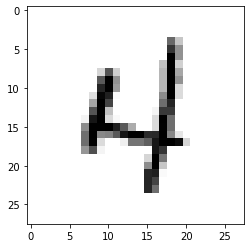

In [20]:
# Understanding the data summaries and samples
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


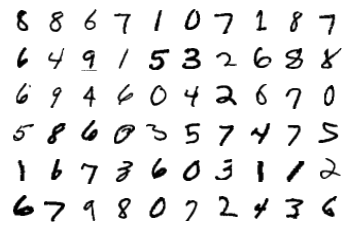

In [21]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining the base model

In [75]:
# The default CNN { conv(32)-> conv(64) -> maxpool -> conv(128) -> conv(256) -> maxpool -> conv(512) -> conv(1024) -> conv(10) -> softmax() } is very bulky
# Code 1: Starting with a base setup that keeps parameter counts low
# Code 2: Adding batch normalization and reducing some of the kernel output channels to keep parameter count <10k
class Net(nn.Module):
    def __init__(self, dropout_value=0.1):
        super(Net, self).__init__()
        self.dropout_value = dropout_value
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # output = 26*26*16, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(self.dropout_value)
        )  # output = 24*24*32, RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            # nn.ReLU(),
            # nn.BatchNorm2d(10),
            # nn.Dropout(self.dropout_value)
        )  # output = 24*24*10, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
           # output = 12*12*10, RF = 5 + (2-1)*1 = 6
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # output = 10*10*16, RF = 6 + (3-1)*2 = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # output = 8*8*16, RF = 10 + (3-1)*2 = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(self.dropout_value)
        ) # output = 6*6*10, RF = 14 + (3-1)*2 = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(self.dropout_value)
        ) # output = 6*6*10, RF = 16 + (3-1)*2 = 20
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output = 1*1*10, RF = 20 + (7-1)*2 = 32
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output = 1*1*10, RF = 32 + (1-1)*4 = 32
        # no batchnorm in the output facing layer
        # no dropout in the output facing layer

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [76]:
# Model params and network summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(dropout_value=0.05).to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0

In [77]:
# Training and testing modules
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [78]:
# model training running for 20 epochs on the skeleton
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1100648045539856 Batch_id=468 Accuracy=85.49: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0717, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.09372628480195999 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0560, Accuracy: 9827/10000 (98.27%)

EPOCH: 2


Loss=0.03317359462380409 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]



Test set: Average loss: 0.0444, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.02350255846977234 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]



Test set: Average loss: 0.0463, Accuracy: 9854/10000 (98.54%)

EPOCH: 4


Loss=0.022410938516259193 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]



Test set: Average loss: 0.0291, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.06997285038232803 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]



Test set: Average loss: 0.0340, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.04140065610408783 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]



Test set: Average loss: 0.0271, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.016165414825081825 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]



Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.03646158054471016 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]



Test set: Average loss: 0.0255, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.009191264398396015 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]



Test set: Average loss: 0.0252, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.042343419045209885 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]



Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.0244844201952219 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]



Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.01818680576980114 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]



Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.03690030053257942 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]



Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.011513885110616684 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]



Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

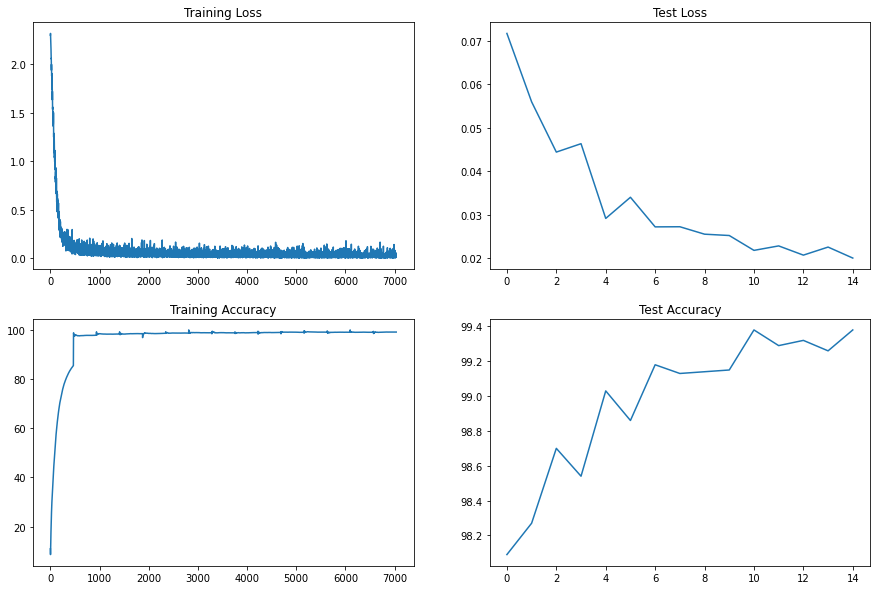

In [79]:
# Loss and accuracy curves for test and training 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:
- Add dropout on each layer
- Introduce GAP with a conv layer to reduce number of params

Results:
- Parameters: 10k
- Best Train Accuracy: 98.77 (till 15 epochs)
- Best Test Accuracy: 99.06 (@ epoch 15 ; till 15 epochs)

Analysis:
- Model has overfit considerably.
- Train and test accuracies have both improved compared to initial skeleton code. Train accuracy has almost maxed out.
- Consistency in test accuracies in later epochs of 99.25 - 99.27
- Adding dropouts to reduce this gap would be a next step
- Adding augmentation to generalize training would be a next step.

Target 2:
- Continue with dropout on each layer
- Continue with GAP with a conv layer to reduce number of params
- Create more features in the inital layers using an expand-squeeze approcah

Results:
- Parameters: 11.4k
- Best Train Accuracy: 99.14 (till 15 epochs)
- Best Test Accuracy: 99.38 (@ multiple epochs ; till 15 epochs)

Analysis:
- Model has not overfit and can further improve.
- Train and test accuracies have both improved compared to batch-norm code.
- Consistency in test accuracies in later epochs of 99.29 - 99.38
- Adding data augmentation would be a next step
- Adding LR optimizer would be a next step